In [1]:
import numpy as np
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from matplotlib import pyplot as plt 
%matplotlib inline

**Based on Andrej Karpathy Walkthrough for language Generation**

https://github.com/karpathy/nn-zero-to-hero/tree/master/lectures/makemore


In [2]:
from typing import NamedTuple, List

In [3]:
file_path = "./names.txt"

with open(file_path, "r") as file:
    words = file.read().splitlines()

In [4]:
len(words), min(len(w) for w in words), max(len(w) for w in words )

(32033, 2, 15)

In [5]:
from enum import Enum
from typing import Dict,Tuple

class SpecialToken(Enum):
    Start : str = '<S>'
    End : str = '<E>'

    def __str__(self):
        return str(self.value)

def build_bigram_model(words: List[str]) -> Tuple[Dict[Tuple[int,int], int] , Dict[int, str]]:

    def compute_alphabet(words: List[str]):
        characters = list(set(''.join(words)))
        sorted_characters = sorted(characters)
        return sorted_characters

    def build_index(alphabets: List[str]):
        char_index = {char: index  for index, char in enumerate(alphabets) }

        char_index[SpecialToken.Start.value] = 26
        char_index[SpecialToken.End.value] = 27

        reverse_index = { index: char for char, index in char_index.items() }

        return char_index, reverse_index

    alphabets = compute_alphabet(words)
    char_index, reverse_index = build_index(alphabets)

    bigram_model = {}

    for word in words:
        prefixed_tokens = [SpecialToken.Start.value] + list(word) + [SpecialToken.End.value]

        for first_char, second_char in zip(prefixed_tokens, prefixed_tokens[1:]):
            bigram = (char_index[first_char], char_index[second_char])

            bigram_model[bigram] = bigram_model.get(bigram, 0) + 1

    return bigram_model, reverse_index

bigram_model, reverse_index = build_bigram_model(words)

bigram_model_sorted = sorted(bigram_model.items(), key = lambda kv : -kv[1])

print("Top 10 bigrams: \n")
bigram_model_sorted[:10]

Top 10 bigrams: 



[((13, 27), 6763),
 ((0, 27), 6640),
 ((0, 13), 5438),
 ((26, 0), 4410),
 ((4, 27), 3983),
 ((0, 17), 3264),
 ((4, 11), 3248),
 ((17, 8), 3033),
 ((13, 0), 2977),
 ((26, 10), 2963)]

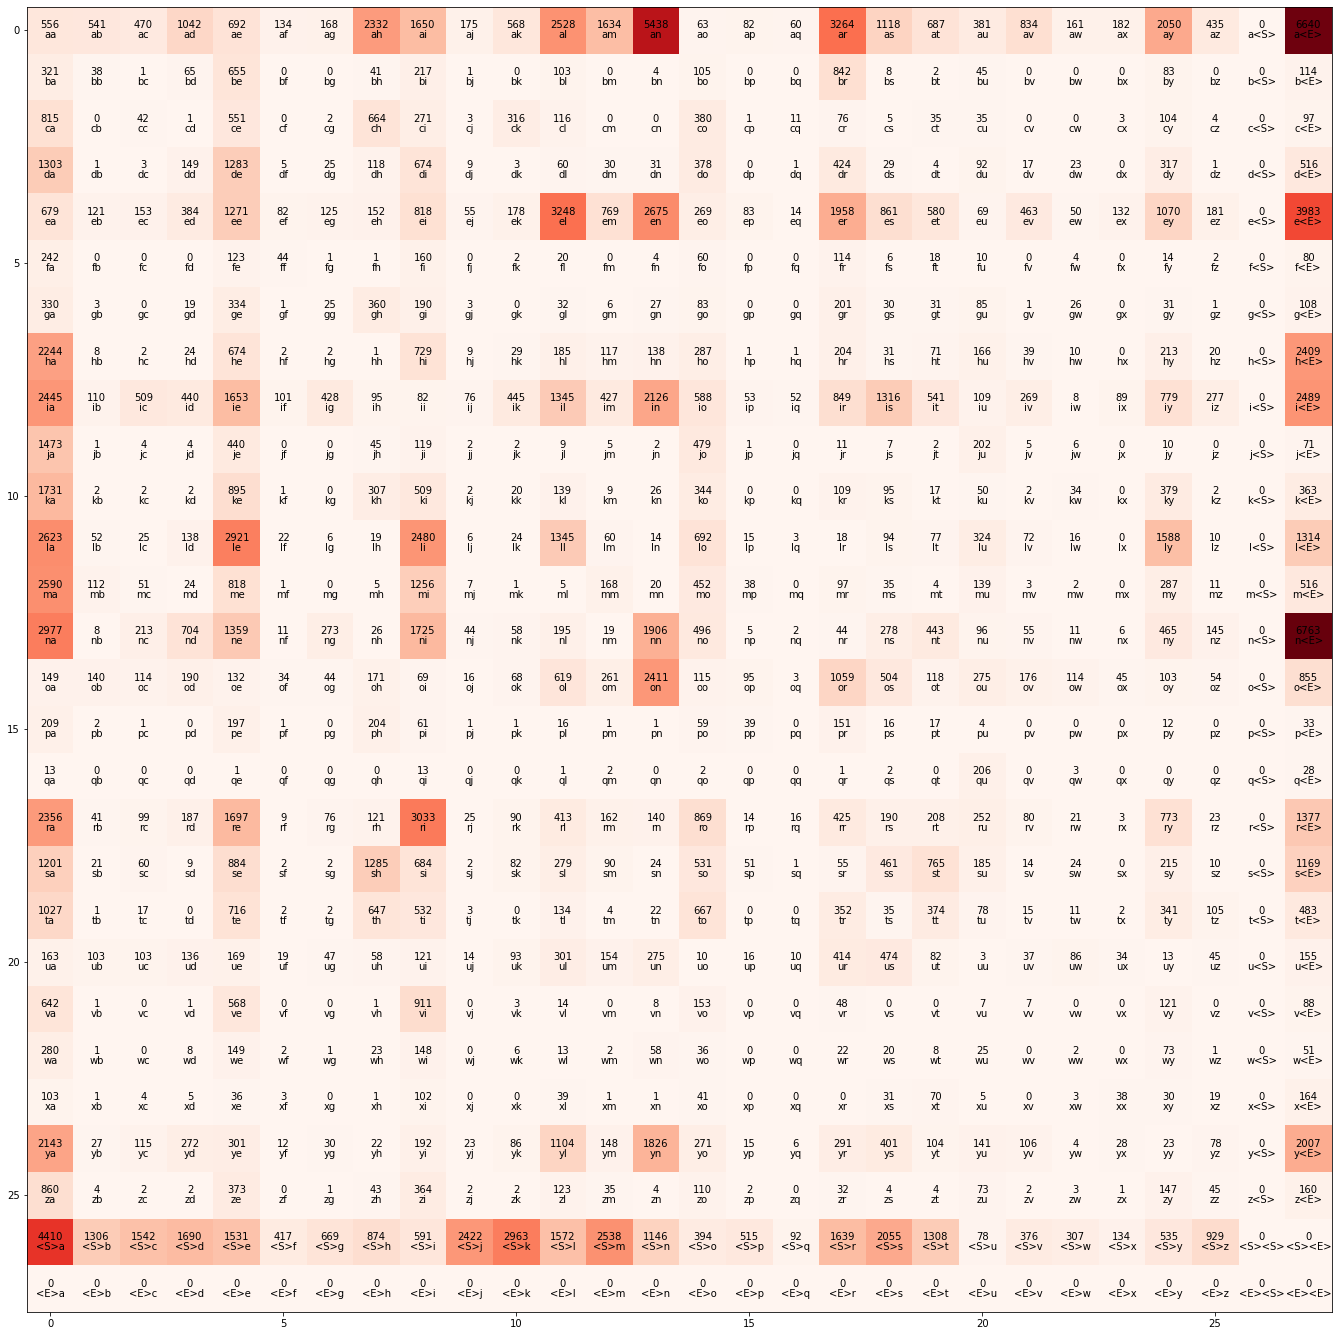

In [6]:
def plot_bigram_model(bigram_model, reverse_index):
    plt.figure(figsize=(24,24))

    data = np.zeros((28,28))

    for i in range(28):
        for j in range(28):
            bigram_str = reverse_index[i] + reverse_index[j]
            plt.text(j, i, bigram_str, ha="center", va="top" , color='black')

            count = bigram_model.get( (i,j), 0 )
            data[i,j] = count
            plt.text(j, i, count, ha="center", va="bottom", color="black" )
    plt.imshow(data, cmap="Reds")

# notice wastage of resources when used seperate start and end symbol in bottom of the plot
plot_bigram_model(bigram_model, reverse_index)

# PyTorch Version

In [7]:
from enum import Enum
from typing import Dict,Tuple

class SpecialToken(Enum):
    Start : str = '.'
    End : str = '.'

    def __str__(self):
        return str(self.value)

def build_bigram_model(words: List[str]) -> Tuple[torch.Tensor , Dict[str, int], Dict[int, str]]:

    def compute_alphabet(words: List[str]):
        characters = list(set(''.join(words)))
        sorted_characters = sorted(characters)
        return sorted_characters

    def build_index(alphabets: List[str]):
        char_index = {char: index + 1  for index, char in enumerate(alphabets) }

        char_index[SpecialToken.Start.value] = 0
        char_index[SpecialToken.End.value] = 0

        reverse_index = { index : char for char, index in char_index.items() }
        return char_index, reverse_index

    alphabets = compute_alphabet(words)
    char_index, reverse_index = build_index(alphabets)

    total_alphabets = len(char_index)

    bigram_model = torch.zeros((total_alphabets, total_alphabets) ) + 0 # label smoothing

    for word in words:
        prefixed_tokens = [SpecialToken.Start.value] + list(word) + [SpecialToken.End.value]

        for first_char, second_char in zip(prefixed_tokens, prefixed_tokens[1:]):
            first, second = (char_index[first_char], char_index[second_char])
            bigram_model[first, second] += 1

    return bigram_model, char_index, reverse_index

bigram_model, character_index, reverse_index = build_bigram_model(words)

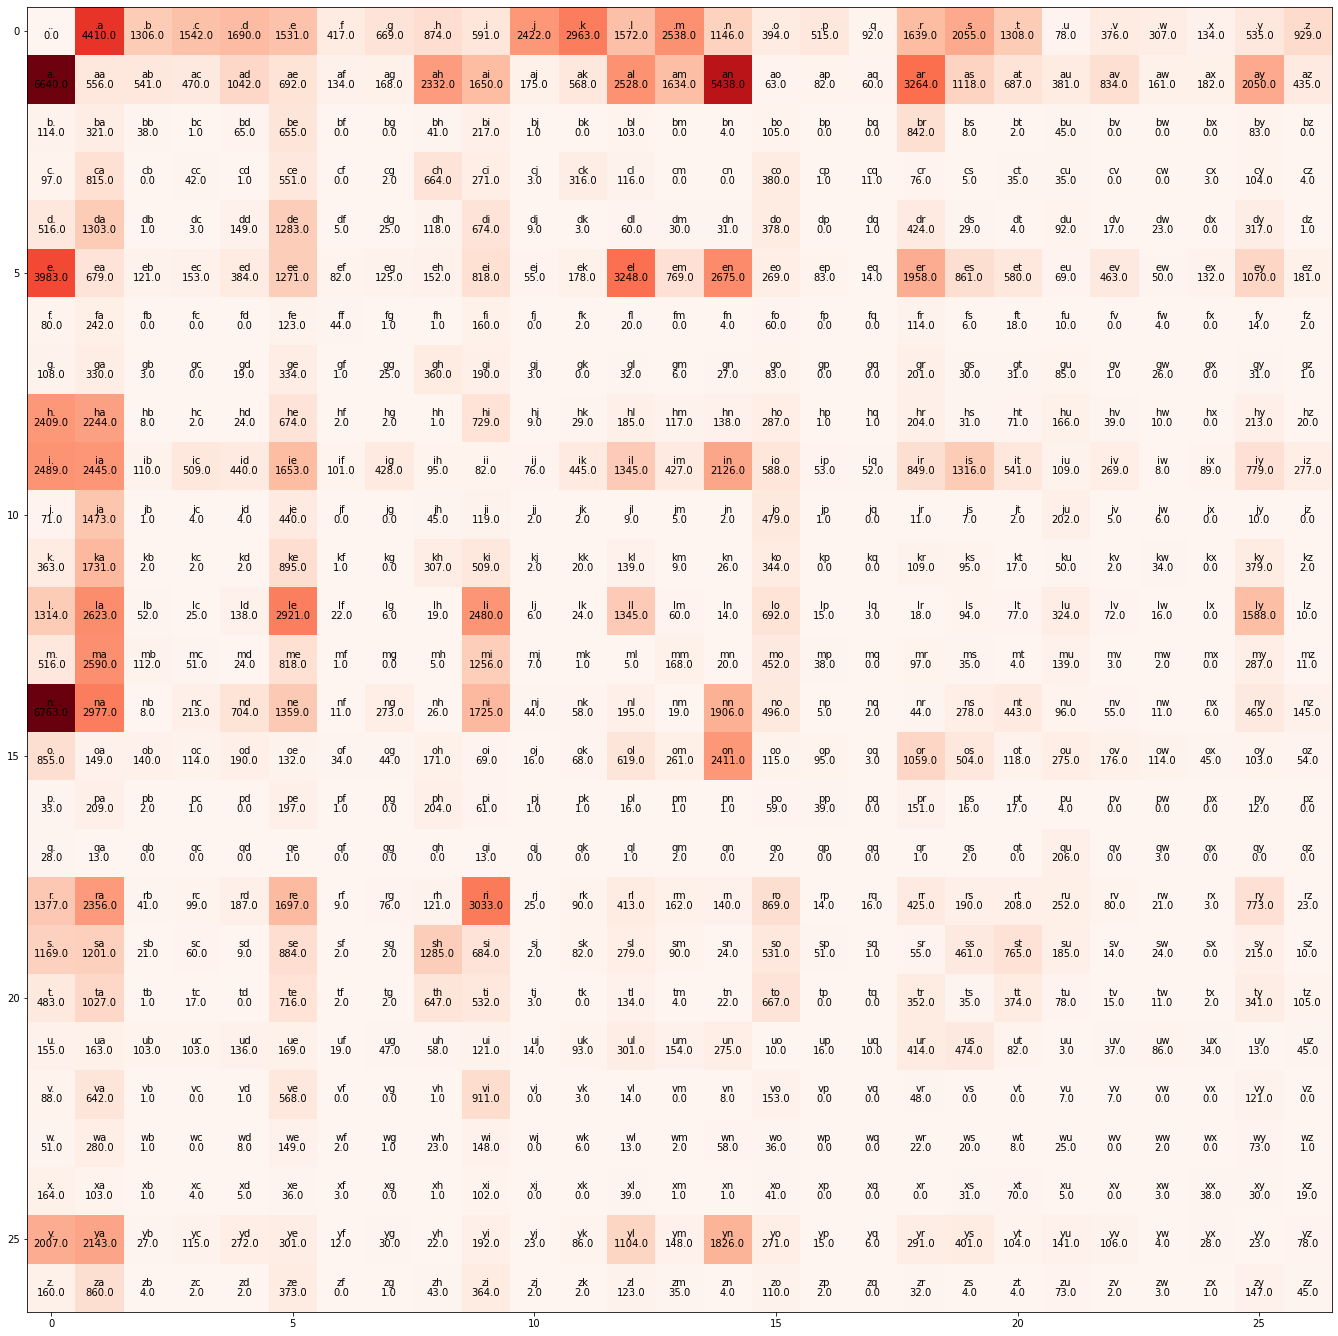

In [8]:

def plot_bigram_tensor_model(bigram_model: torch.Tensor, reverse_index: Dict[int,str]):
    plt.figure(figsize=(24,24))

    height, width = bigram_model.shape

    data = np.zeros((height, width))

    for i in range(height):
        for j in range(width):
            bigram_str = reverse_index[i] + reverse_index[j]
            plt.text(j, i, bigram_str, ha="center", va="bottom" , color='black')

            count = bigram_model[i,j].item()
            data[i,j] = count
            plt.text(j, i, count, ha="center", va="top", color="black" )
    plt.imshow(data, cmap="Reds")
plot_bigram_tensor_model(bigram_model, reverse_index)


In [9]:
def compute_prob_distribution(bigram_model: torch.Tensor):
    smoothing_factor = 2 # label smoothing is important otherwise we will get infinity in log likelihood calculation
    x = bigram_model + smoothing_factor

    prob = x.float() / x.sum(dim=1, keepdim=True)
    return prob

probability_dist = compute_prob_distribution(bigram_model)

gen = torch.Generator().manual_seed(42)

def sample(bigram_prob_distribution: torch.Tensor, reverse_index: Dict[int, str], generator: torch.Generator = None):
    index = 0
    sampled_chars = []
    while True:
        prob = bigram_prob_distribution[index]
        index = torch.multinomial(prob, 1, True,generator=generator).item()
        character = reverse_index[index]
        if index == 0:
            break
        sampled_chars.append(character)
    return ''.join(sampled_chars)

def compute_loss(bigram_prob_dist: torch.Tensor, character_index: Dict[str, int],  words: List[str]):
    log_likelihood = 0.0
    eps = 1e-10
    counter = 0
    for word in words:
        prefixed_word = [SpecialToken.Start.value] + list(word) + [SpecialToken.End.value]
        for first, second in zip(prefixed_word, prefixed_word[1:]):
            x,y = character_index[first], character_index[second]
            prob = bigram_prob_dist[x,y].log().item()
            log_likelihood += prob
            counter += 1
    # compute negative log likelihood
    return -log_likelihood/ (counter + eps)

    #bigram_prob_dist = torch.randn((5,5))
    #nll = -bigram_prob_dist.log().mean()
    #return nll

nll = compute_loss(probability_dist,character_index, words)

print(f"Loss: {nll}")

print("Generated words: ")

for i in range(5):
    generated_word = sample(probability_dist, reverse_index, gen)
    print(generated_word)


Loss: 2.455271362498888
Generated words: 
a
a
keys
a
hmone


# Single Layer Neural Network Version

In [10]:
def prepare_data_set(words: List[str], character_index: Dict[str, int]):
    xs, ys = [], []
    for word in words:
        for first, second in zip(word, word[1:]):
            x, y = character_index[first], character_index[second]
            xs.append(x)
            ys.append(y)

    return torch.tensor(xs), torch.tensor(ys)

xs, ys = prepare_data_set(words, character_index)
        

In [11]:
def network(xs: torch.Tensor, ys: torch.Tensor, num_classes):
    def compute_loss(input: torch.Tensor, weights: torch.Tensor, num_classes: int):
        # input to network: one-hot encoded
        encoded_xs: torch.Tensor = F.one_hot(input, num_classes).float()

        # encoded_xs -> batch of one hot encoded row-vector
        # weights -> column vector representing a neuron
        # multiplying encoded_xs and weights i.e., encoded_xs @ weight 
        # is equivalent to parellel processing of input batch by multiple neurons in parallel. 

        #logits = encoded_xs.matmul(weights)
        logits = encoded_xs @ weights    # unnormalized log probability
        
        count = logits.exp() # e^logx = x

        #keepDim=True is crucial otherwise broadcasting will be wrong
        # resulting in incorrect probability.   
        probabilities = count / count.sum(dim=1,keepdim=True)

        # probabilities should sum to 1
        #print(probabilities.sum(dim=1, keepdim=True))

        # use array indexing to access predicted probabilities directly        
        predicted_probs = probabilities[ torch.arange(xs.shape[0]), ys ]
        nll_avg = -predicted_probs.log().mean() + 0.01*(weights**2).mean()   # regularization
        return nll_avg

        # #shortcut method
        # nll2 = F.cross_entropy(log_count, ys)
        # print("Negative log likelihood: ", nll2)

    # equivalent to single layer of (num_classes = 27) neurons(each column vector represents neuron)
    weights = torch.randn((num_classes, num_classes), requires_grad=True)
    epoch_count = 100

    losses = []

    for epoch in range(1, epoch_count + 1):
        loss = compute_loss(xs, weights, num_classes)

        weights.grad = None
        loss.backward()
        weights.data += -40 * weights.grad

        losses.append(loss.item())

        #print(f"Epoch: {epoch}, loss: {loss.item()}")
    return losses

losses = network(xs, ys,num_classes=len(character_index))

Final loss:  2.3841960430145264


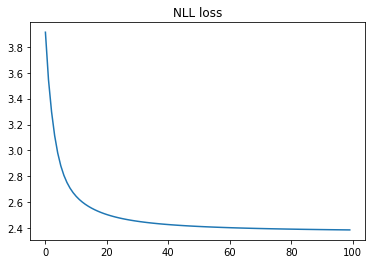

In [12]:
def plot_losses(losses: List[float]):
    plt.figure()
    plt.title("NLL loss")
    plt.plot(np.arange(len(losses)), losses)
    plt.show()

print("Final loss: ", losses[-1])
plot_losses(losses)
